In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:

import numpy as np
import pandas as pd

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
#from keras.utils.vis_utils import plot_model
from PIL import Image

In [19]:
train_directory = ('/content/drive/MyDrive/Pneumonia_data/chest_xray/train')
test_directory = ('/content/drive/MyDrive/Pneumonia_data/chest_xray/test')
val_directory = ('/content/drive/MyDrive/Pneumonia_data/chest_xray/val')


In [20]:
data_dir = train_directory
class_names=os.listdir(train_directory)
#class_names.pop()
print(class_names)

['PNEUMONIA', 'NORMAL']


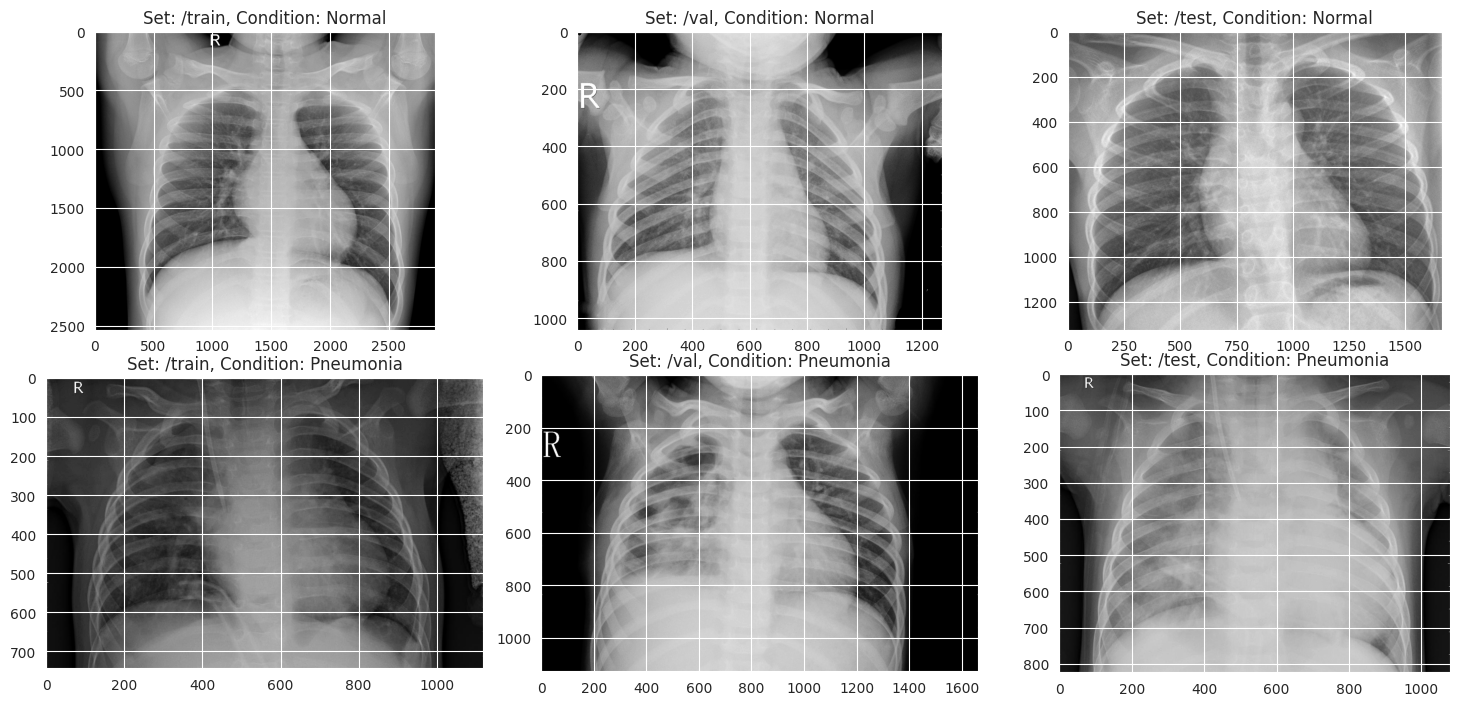

In [24]:
#Random vizualization from all directories

input_path="/content/drive/MyDrive/Pneumonia_data/chest_xray"
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['/train', '/val', '/test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [25]:
for _set in ['/train', '/val', '/test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, Normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: /train, Normal images: 1341, pneumonia images: 3875
Set: /val, Normal images: 8, pneumonia images: 8
Set: /test, Normal images: 234, pneumonia images: 390


In [26]:
# Re-sizing the images
IMAGE_SIZE = (224, 224)
# Default batch size
BATCH_SIZE = 32

In [28]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

# Define data augmentation settings
Image_gen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)



In [29]:
train = Image_gen.flow_from_directory(train_directory,
                                       batch_size=32,
                                       class_mode='binary',
#                                        target_size=(224,224,3))
                                       )

validation = Image_gen.flow_from_directory(val_directory,
                                              batch_size=2,
                                              class_mode='binary',
#                                               target_size=(224,224,3))
                                            )

test = val_Datagen.flow_from_directory(test_directory,
                                       batch_size=2,
                                       class_mode='binary',
#                                        target_size=(224/,224,3))
                                      )


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [30]:
img, label = next(train)

In [31]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10)

In [32]:
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          patience=8)

In [33]:
def create_model():
    resnet_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top = False,
        input_shape = (224,224,3)
    )

    for layer in resnet_model.layers:
        layer.trainable=False

    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    # output layer
    predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

    res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

    # Compiling the model
    res_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return res_model

In [34]:
res_model = create_model()

94668760/94668760 [==============================] - 0s 0us/step


In [35]:
res_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [37]:
history = res_model.fit(train,epochs=30,
                    validation_data=validation,
                     steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/30
100/100 [==============================] - 96s 959ms/step - loss: 0.1322 - accuracy: 0.9494 - val_loss: 0.7649 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 2/30
100/100 [==============================] - 94s 931ms/step - loss: 0.1266 - accuracy: 0.9522 - val_loss: 0.1299 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 3/30
100/100 [==============================] - 100s 975ms/step - loss: 0.1286 - accuracy: 0.9478 - val_loss: 0.5798 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 4/30
100/100 [==============================] - 97s 964ms/step - loss: 0.1307 - accuracy: 0.9481 - val_loss: 0.4602 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 5/30
100/100 [==============================] - 93s 929ms/step - loss: 0.1193 - accuracy: 0.9519 - val_loss: 0.2902 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 6/30
100/100 [==============================] - 93s 931ms/step - loss: 0.1301 - accuracy: 0.9466 - val_loss: 0.3303 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 7/30
100/100 [=======

Text(0, 0.5, 'Loss')

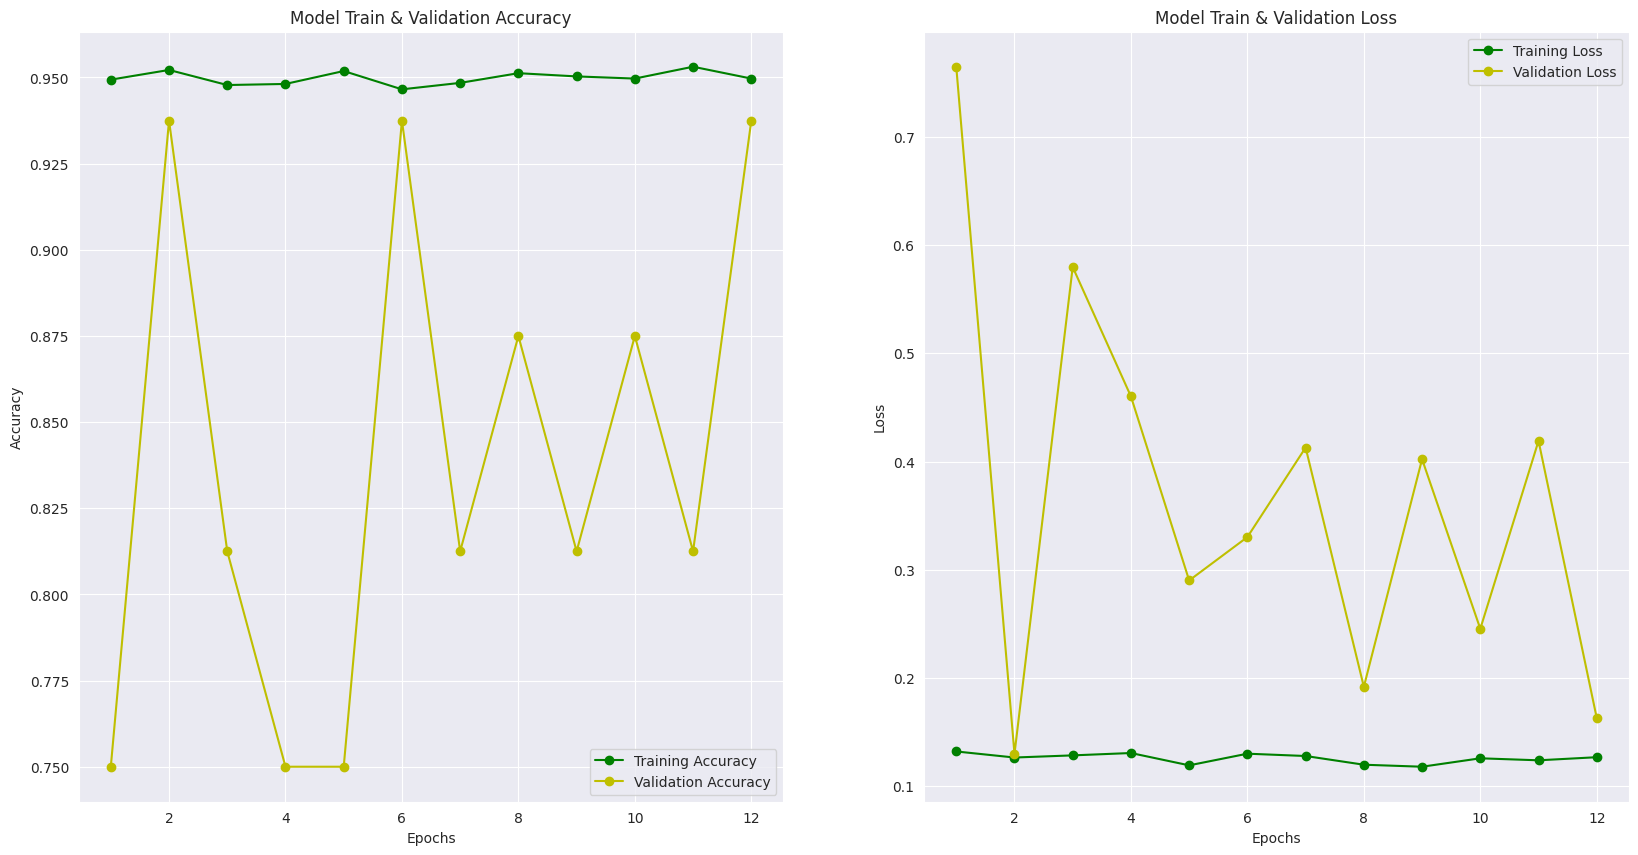

In [38]:
#Plot the training artifacts
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('Model Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs, val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

In [39]:
print("Accuracy of the model is - " , res_model.evaluate(test)[1]*100 , "%")

312/312 [==============================] - 178s 572ms/step - loss: 0.2086 - accuracy: 0.9279
Accuracy of the model is -  92.78846383094788 %


In [ ]:
# Vgg19

In [80]:
def Create_model():
  VGG19_model = tf.keras.applications.vgg19.VGG19(weights='imagenet',include_top = False,input_shape = (224,224,3))
  for layer in VGG19_model.layers:
        layer.trainable=False

  x = VGG19_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(128,activation='relu')(x)
  # output layer
  predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

  VGG19_model = tf.keras.Model(inputs=VGG19_model.input, outputs=predictions)

  # Compiling the model
  VGG19_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
  return VGG19_model

In [81]:
VGG19_model = Create_model()

In [82]:
VGG19_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [83]:
history = VGG19_model.fit(train,epochs=30,
                    validation_data=validation,
                     steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/30
100/100 [==============================] - 103s 953ms/step - loss: 0.4853 - accuracy: 0.7641 - val_loss: 0.7481 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - 97s 963ms/step - loss: 0.4146 - accuracy: 0.8028 - val_loss: 0.8526 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - 99s 988ms/step - loss: 0.3773 - accuracy: 0.8275 - val_loss: 0.8504 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - 95s 953ms/step - loss: 0.3780 - accuracy: 0.8269 - val_loss: 0.6849 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/30
100/100 [==============================] - 96s 951ms/step - loss: 0.3487 - accuracy: 0.8425 - val_loss: 0.5794 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 6/30
100/100 [==============================] - 95s 952ms/step - loss: 0.3213 - accuracy: 0.8528 - val_loss: 0.8602 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 7/30
100/100 [==============================]

Text(0, 0.5, 'Loss')

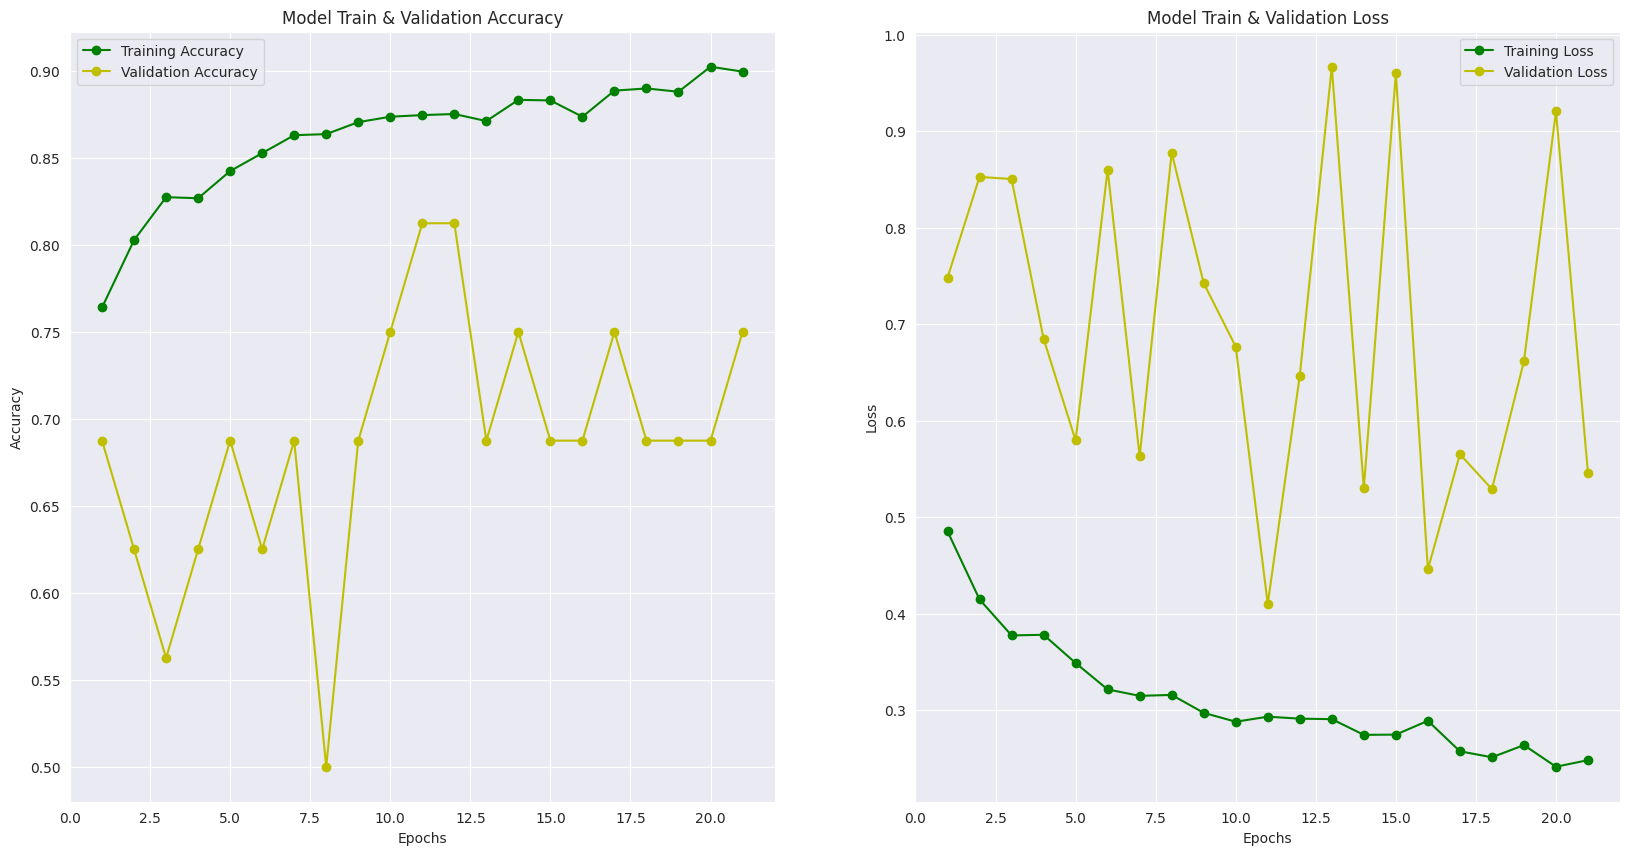

In [84]:
#Plot the training artifacts
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('Model Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs, val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

In [85]:
print("Accuracy of the model is - " , VGG19_model.evaluate(test)[1]*100 , "%")

312/312 [==============================] - 8s 26ms/step - loss: 0.3390 - accuracy: 0.8590
Accuracy of the model is -  85.89743375778198 %


In [73]:
# Inception V3

In [86]:
def Create_Model():
  Inc_model = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet',include_top = False,input_shape = (224,224,3))
  for layer in Inc_model.layers:
        layer.trainable=False

  x = Inc_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(128,activation='relu')(x)
  # output layer
  predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

  Inc_model = tf.keras.Model(inputs=Inc_model.input, outputs=predictions)

  # Compiling the model
  Inc_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
  return Inc_model

In [87]:
Inc_model = Create_Model()

In [88]:
Inc_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_108 (Conv2D)         (None, 111, 111, 32)         864       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_108 (B  (None, 111, 111, 32)         96        ['conv2d_108[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_94 (Activation)  (None, 111, 111, 32)         0         ['batch_normalization_10

In [89]:
history = Inc_model.fit(train,epochs=30,
                    validation_data=validation,
                     steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/30
100/100 [==============================] - 102s 922ms/step - loss: 0.3524 - accuracy: 0.8350 - val_loss: 0.9748 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - 90s 897ms/step - loss: 0.2910 - accuracy: 0.8728 - val_loss: 0.9686 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - 90s 899ms/step - loss: 0.2685 - accuracy: 0.8881 - val_loss: 0.6417 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - 98s 978ms/step - loss: 0.2269 - accuracy: 0.9056 - val_loss: 0.5759 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 5/30
100/100 [==============================] - 90s 902ms/step - loss: 0.2581 - accuracy: 0.8966 - val_loss: 0.3599 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 6/30
100/100 [==============================] - 92s 920ms/step - loss: 0.2242 - accuracy: 0.9116 - val_loss: 0.4522 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 7/30
100/100 [==============================]

Text(0, 0.5, 'Loss')

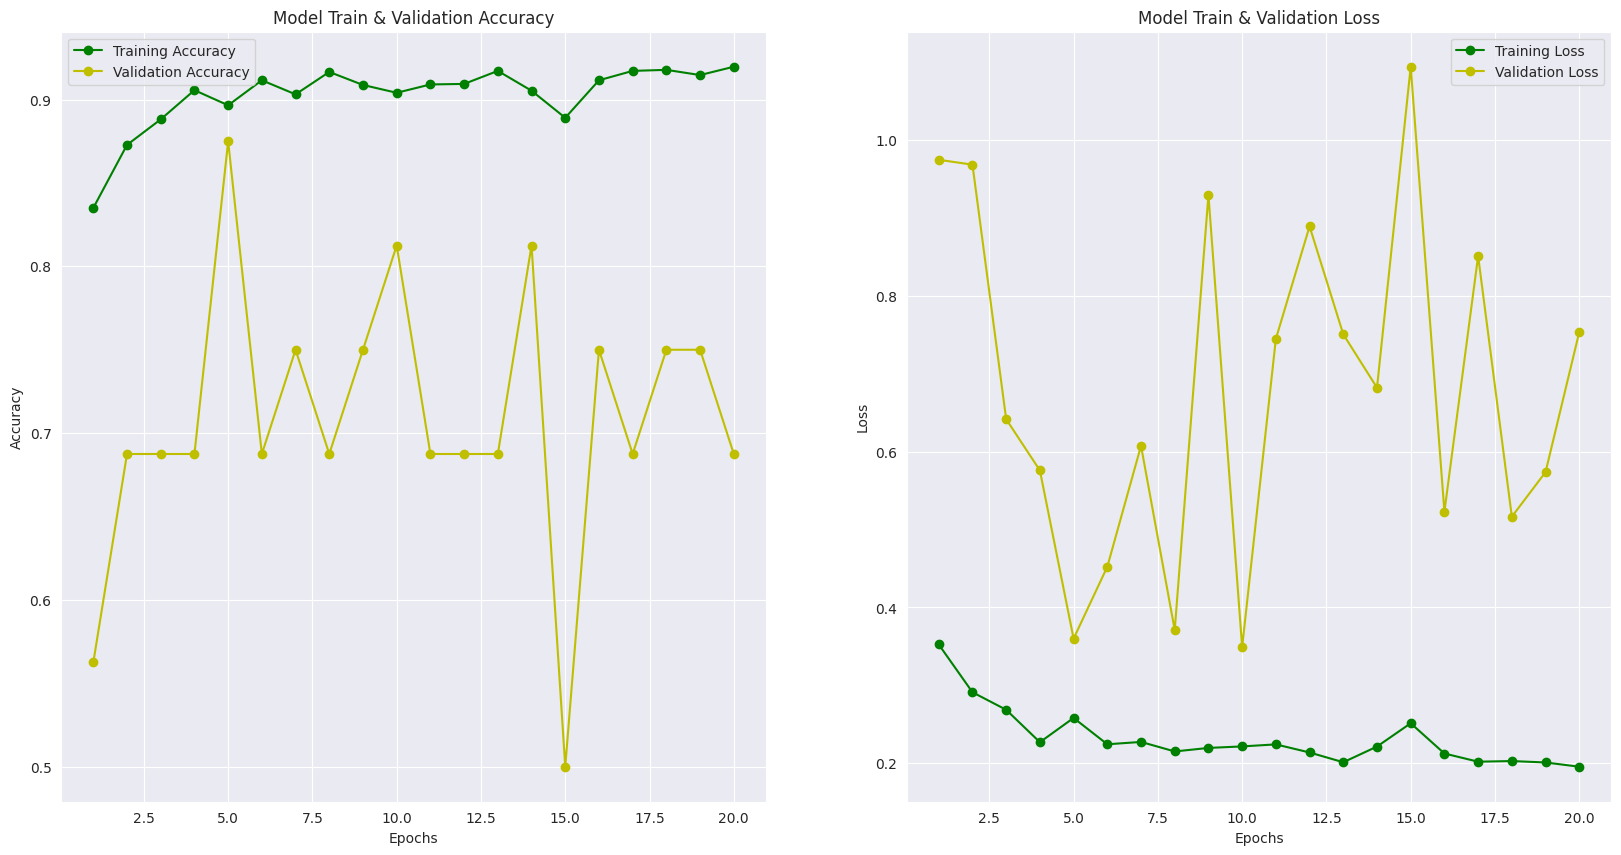

In [90]:
#Plot the training artifacts
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('Model Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs, val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

In [91]:
print("Accuracy of the model is - " , Inc_model.evaluate(test)[1]*100 , "%")

312/312 [==============================] - 8s 24ms/step - loss: 0.3602 - accuracy: 0.8413
Accuracy of the model is -  84.13461446762085 %
